In [55]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;


%matplotlib inline

# For Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For building the LSTM Model
from keras.models import Sequential
from keras.layers import LSTM, Dense

# For evaluating the model
from sklearn.metrics import mean_squared_error

data = pd.read_csv('Data/Powietrze_2019-2022_Pilsudzkiego.csv', sep=';', parse_dates=['Data'])

In [56]:
data.dropna(inplace=True)

In [57]:
data_df = data

In [58]:
data_df.rename(columns = {'(pył zawieszony PM2.5 [jednostka ug/m3])':'PM2.5'
                    , '(pył zawieszony PM10 [jednostka ug/m3])':'PM10'
                    , '(tlenek azotu [jednostka ug/m3])':'NO'
                    , '(tlenki azotu [jednostka ug/m3])':'NOs'
                    , '(tlenek węgla [jednostka ug/m3])':'CO'
                    , '(benzen [jednostka ug/m3])':'benzen'
                    , '(dwutlenek azotu [jednostka ug/m3])':'NO2'
                    }, inplace = True)

In [59]:
data

,Data,PM2.5,PM10,NO,NOs,CO,benzen,NO2
0,2019-01-03 07:00:00,6.8,7.3,25.1,75.7,0.3,0.5,37.3
1,2019-01-06 08:00:00,16.1,16.8,13.6,34.4,0.3,0.5,13.5
2,2019-01-15 03:00:00,9.9,10.3,0.9,7.3,0.3,0.5,6.0
3,2019-01-15 04:00:00,9.6,10.0,0.6,7.7,0.3,0.5,6.7
4,2019-03-08 05:00:00,6.8,10.3,21.4,71.6,0.3,0.5,38.9
...,...,...,...,...,...,...,...,...
26203,2021-12-29 22:00:00,140.6,155.4,128.1,284.7,2.2,8.9,88.4
26204,2021-12-29 23:00:00,144.0,157.4,60.7,161.3,2.1,9.4,68.3
26205,2021-12-30 00:00:00,144.7,157.6,67.2,167.3,2.1,9.9,64.3
26206,2021-12-30 01:00:00,133.1,146.1,79.7,184.6,2.1,10.1,62.4


In [60]:
data_df = data_df.reset_index()
six_df = pd.DataFrame()
twelve_df = pd.DataFrame()
tf_df = pd.DataFrame()
for i in range(len(data_df)):
    six_df = pd.concat([six_df,pd.DataFrame({'PM2.5 6hr_avg':[sum(data_df['PM2.5'].iloc[i:i+6])/6]}, index = [i+6])])
    twelve_df = pd.concat([twelve_df,pd.DataFrame({'PM2.5 12hr_avg':[sum(data_df['PM2.5'].iloc[i:i+12])/12]}, index = [i+12])])
    tf_df = pd.concat([tf_df,pd.DataFrame({'PM2.5 24hr_avg':[sum(data_df['PM2.5'].iloc[i:i+24])/24]}, index = [i+24])])
   
data_df = pd.merge(data_df, six_df, left_index=True, right_index=True)
data_df = pd.merge(data_df, twelve_df, left_index=True, right_index=True)
data_df = pd.merge(data_df, tf_df, left_index=True, right_index=True)


In [61]:
data_df['H'] = pd.to_datetime(data_df['Data']).dt.time
data_df['H'] = data_df['H'].astype('string')

In [62]:
data_df['H'] = data_df['H'].str.replace(r'\D', '')

C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\4249282884.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['H'] = data_df['H'].str.replace(r'\D', '')


In [63]:
data_df['H'] = data_df['H'].str.replace(r'.{4}$', '')


C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\1843561337.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['H'] = data_df['H'].str.replace(r'.{4}$', '')


In [64]:
data_df['H'] = data_df['H'].astype('float')

In [65]:
data_df = data_df.drop('index', axis=1)
data_df['Data'] = pd.to_datetime(data_df['Data'], format='%Y%m%d %H')
data_df.index = data_df['Data']
data_df = data_df.drop('Data', axis=1)

In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(data_df)
data_df2 = pd.DataFrame(values)

In [69]:
data_df2.columns = data_df.columns
data_df2.index = data_df.index 

In [70]:
data_df2.dropna(inplace=True)

In [71]:
dataset = np.log1p(data_df2[['PM2.5']].values)
dataset.shape

(24244, 1)

<Figure size 864x360 with 0 Axes>

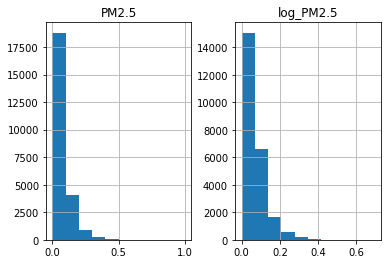

In [72]:
dist_df = pd.DataFrame({'PM2.5' : data_df2['PM2.5'].values, 'log_PM2.5' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [73]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

19395 4849


In [74]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [75]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (19393, 1)
Shape of trainY : (19393,)
Shape of testX : (4847, 1)
Shape of testY : (4847,)


In [76]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (19393, 1, 1)
Shape of testX : (4847, 1, 1)


In [77]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
607/607 - 3s - loss: 8.8594e-04 - 3s/epoch - 6ms/step
Epoch 2/100
607/607 - 1s - loss: 4.5519e-04 - 1s/epoch - 2ms/step
Epoch 3/100
607/607 - 1s - loss: 4.2106e-04 - 1s/epoch - 2ms/step
Epoch 4/100
607/607 - 2s - loss: 4.2223e-04 - 2s/epoch - 3ms/step
Epoch 5/100
607/607 - 2s - loss: 4.2195e-04 - 2s/epoch - 3ms/step
Epoch 6/100
607/607 - 1s - loss: 4.2154e-04 - 1s/epoch - 2ms/step
Epoch 7/100
607/607 - 1s - loss: 4.2125e-04 - 1s/epoch - 2ms/step
Epoch 8/100
607/607 - 1s - loss: 4.2131e-04 - 1s/epoch - 2ms/step
Epoch 9/100
607/607 - 1s - loss: 4.2094e-04 - 1s/epoch - 2ms/step
Epoch 10/100
607/607 - 2s - loss: 4.2184e-04 - 2s/epoch - 3ms/step
Epoch 11/100
607/607 - 1s - loss: 4.2150e-04 - 997ms/epoch - 2ms/step
Epoch 12/100
607/607 - 1s - loss: 4.2110e-04 - 1s/epoch - 2ms/step
Epoch 13/100
607/607 - 1s - loss: 4.2264e-04 - 1s/epoch - 2ms/step
Epoch 14/100
607/607 - 1s - loss: 4.2139e-04 - 1s/epoch - 2ms/step
Epoch 15/100
607/607 - 2s - loss: 4.2133e-04 - 2s/epoch - 3ms/step
E

In [78]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.08 RMSE


In [79]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
0.08 < 0.11


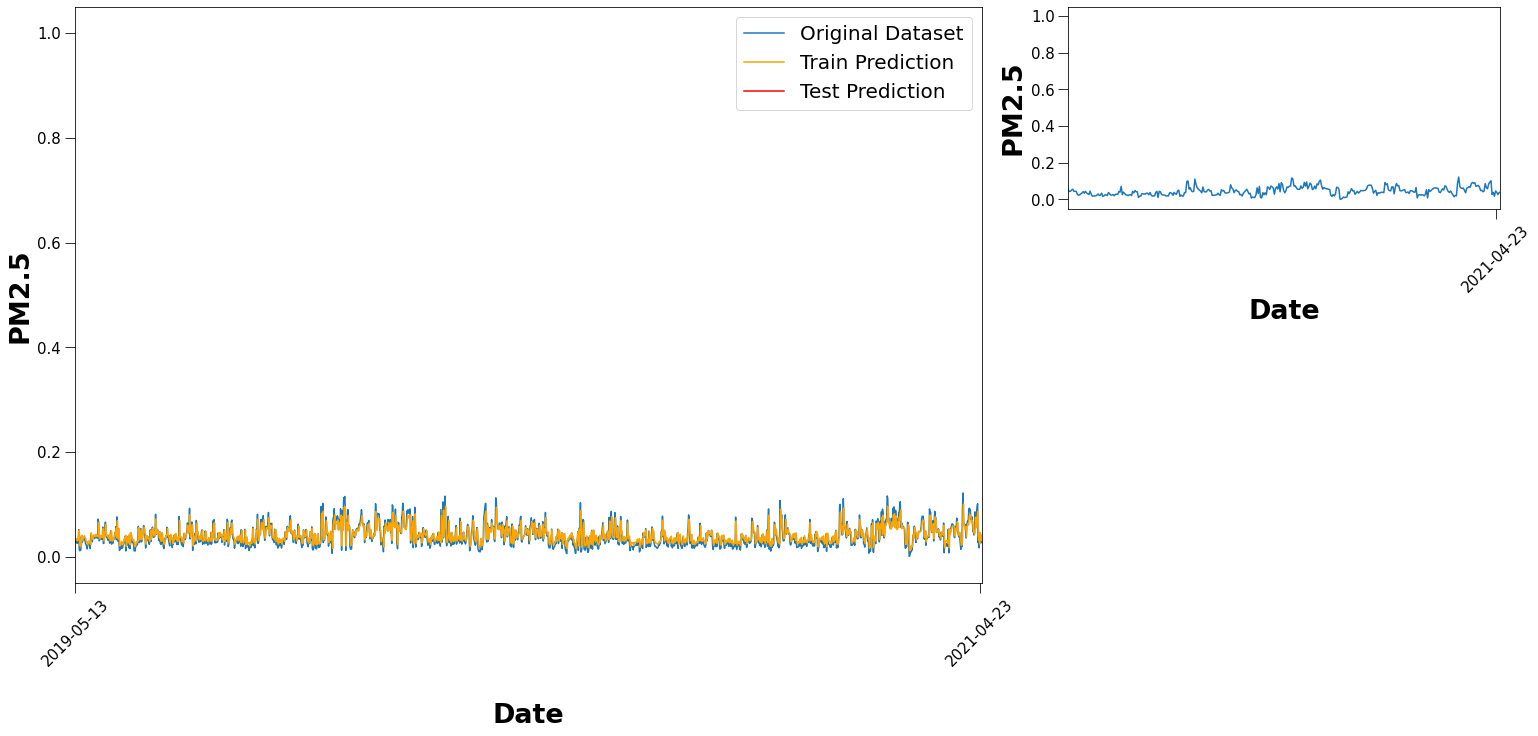

In [80]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data_df.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('PM2.5', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('PM2.5', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

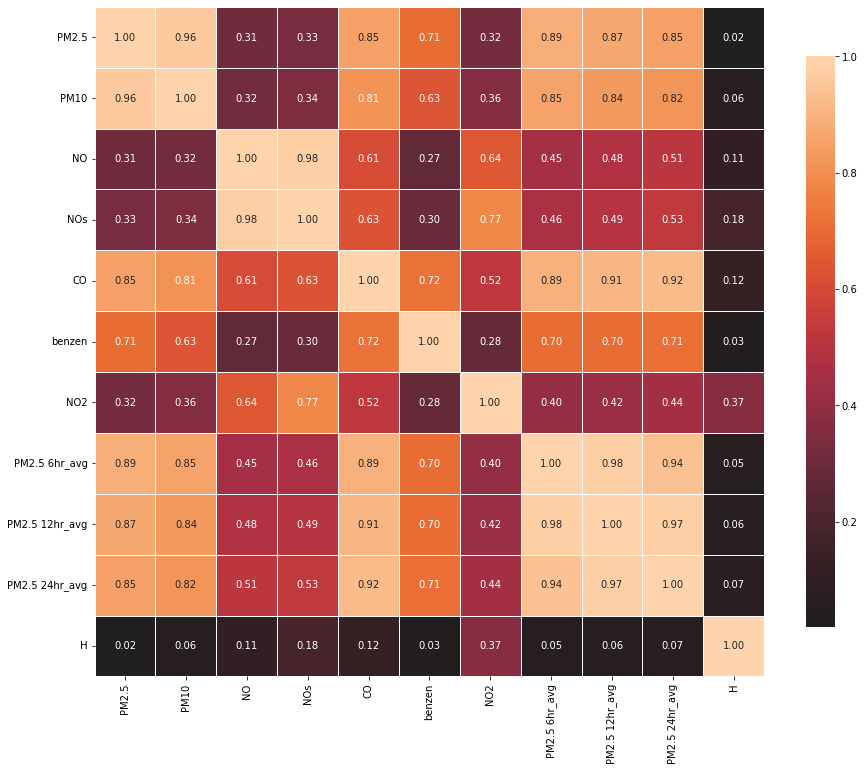

In [81]:
correlations = data_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

In [96]:
data_df = data_df.drop('Data', axis=1)
data_df = data_df.reset_index()

In [107]:
data_df['M'] = pd.to_datetime(data_df['Data']).dt.month

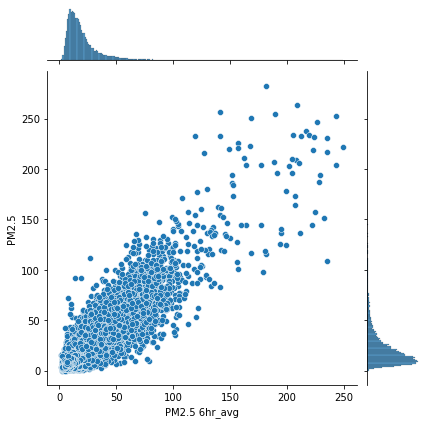

In [97]:
sns.jointplot(x=data_df['PM2.5 6hr_avg'], y=data_df['PM2.5'], data = data_df)

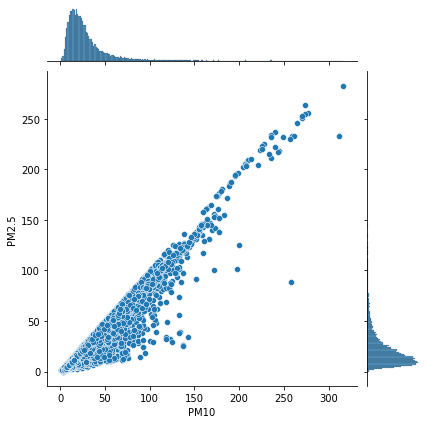

In [98]:
sns.jointplot(x=data_df['PM10'], y=data_df['PM2.5'], data = data_df)

In [89]:
data_df['Data'] = pd.to_datetime(data['Data'], format='%Y%m%d %H')
data.groupby(pd.to_datetime(data['Data']).dt.hour).count()


,Data,PM2.5,PM10,NO,NOs,CO,benzen,NO2
Data,,,,,,,,
0,1017,1017,1017,1017,1017,1017,1017,1017
1,996,996,996,996,996,996,996,996
2,1015,1015,1015,1015,1015,1015,1015,1015
3,1012,1012,1012,1012,1012,1012,1012,1012
4,1010,1010,1010,1010,1010,1010,1010,1010
5,1014,1014,1014,1014,1014,1014,1014,1014
6,1026,1026,1026,1026,1026,1026,1026,1026
7,1027,1027,1027,1027,1027,1027,1027,1027
8,1019,1019,1019,1019,1019,1019,1019,1019


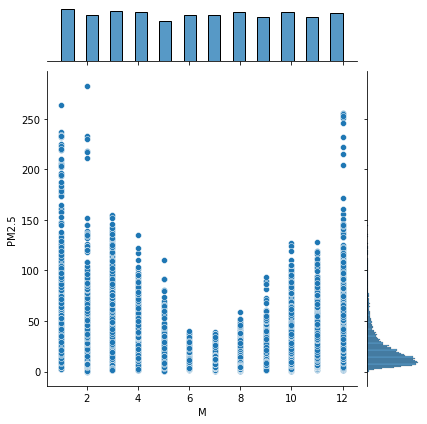

In [108]:
sns.jointplot(x=data_df['M'], y=data_df['PM2.5'], data = data_df)

In [ ]:
temp_df = pd.DataFrame()
for i in range(len(data_df)):
    temp_df = pd.concat([temp_df,pd.DataFrame({'PM2.5 6hr_avg':[sum(data_df['AirTemperature'].iloc[i:i+6])/6]}, index = [i+6])]) 
data_df = pd.merge(data_df, six_df, left_index=True, right_index=True)